In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import fasttext.util

In [6]:
#removing punctuations, lowercasing wordss, splitting words
def tokenize(text):
    punctuations = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'
    for punctuation in punctuations:
        text = text.replace(punctuation, '')
    text = text.lower() 
    text = text.split()
    return text

#filling missing data
def fill_missing_range(df, field, range_from, range_to, range_step=1, fill_with=0):
    return df\
      .merge(how='right', on=field,
            right = pd.DataFrame({field:np.arange(range_from, range_to, range_step)}))\
      .sort_values(by=field).reset_index().fillna(fill_with).drop(['index'], axis=1)

In [7]:
#reading csv and subsetting per topic
text = pd.read_excel('statements.xlsx')
votes = pd.read_excel('votes.xlsx')

mig = text.loc[text['zid'] == 8]
sex = text.loc[text['zid'] == 9]
rel = text.loc[text['zid'] == 10]

#adding statements to list
statements_mig = []
statements_mig.extend(mig['txt'].tolist())

statements_sex = []
statements_sex.extend(sex['txt'].tolist())

statements_rel = []
statements_rel.extend(rel['txt'].tolist())

#tokenizing statements for every topic
tokenized_statements_mig = [tokenize(text) for text in statements_mig]
tokenized_statements_sex = [tokenize(text) for text in statements_sex]
tokenized_statements_rel = [tokenize(text) for text in statements_rel]

In [8]:
#load in fasttext model for dutch words
ft = fasttext.load_model('cc.nl.300.bin') #Dutch word embeddings with 300 dimensions

In [9]:
[ft[x] for x in tokenized_statements_mig[0]] #vector for every word
np.array([ft[x] for x in tokenized_statements_mig[36]]).mean(axis=0) #vector for every sentence, sum of average -> sentence2vec

array([ 3.76682319e-02,  8.16188194e-03,  7.45323021e-04, -1.90000013e-02,
        2.29384378e-03,  6.84473058e-03,  1.03994450e-02, -3.37715112e-02,
       -2.33927798e-02, -2.46131197e-02,  4.19596164e-03,  9.96658765e-03,
       -1.50435546e-03,  2.26912219e-02,  2.57256366e-02, -2.65470818e-02,
       -1.71524640e-02,  3.83652374e-03, -1.37608666e-02,  2.48444732e-03,
        8.97130114e-04,  5.48627041e-03, -8.99775047e-03,  2.72788741e-02,
       -2.90880445e-02, -1.72245689e-02, -1.46569684e-02, -1.54762287e-02,
       -6.12155069e-04, -2.46702917e-02, -1.18790511e-02, -5.01309857e-02,
        2.86203846e-02, -1.83280576e-02, -1.19735077e-02,  5.71405794e-03,
        2.07362063e-02,  5.43035986e-03, -1.11692622e-02,  2.00474728e-02,
       -3.09395753e-02, -7.17769712e-02, -7.59031577e-03,  1.61658209e-02,
       -2.54078768e-02,  2.41631176e-02, -1.24399960e-02, -1.19399140e-02,
       -1.98164061e-02,  2.17591389e-03, -6.42508455e-03,  5.88247776e-02,
        2.01615822e-02, -

In [14]:
#Creating empty list
mig_vec = []
sex_vec = []
rel_vec = []

#Looping over every tokenized statement and applying sentence2vec, then appending it to list
for i in tokenized_statements_mig:
    mig_vec.append(np.array([ft[x] for x in i]).mean(axis=0))

for i in tokenized_statements_sex:
    sex_vec.append(np.array([ft[x] for x in i]).mean(axis=0))
    
for i in tokenized_statements_rel:
    rel_vec.append(np.array([ft[x] for x in i]).mean(axis=0))


In [15]:
#Looping over all statements and calculating semantic similarity distance using cosine measure
stat_mig = []
comp_mig = []
dist_mig = []
tid_mig = []
statement = 0
count = 0
tid = -1
for i in mig_vec:
    tid += 1 #creating own count for statement ids
    statement += 1
    for j in mig_vec:
        count += 1
        count = count % 37
        tid_mig.append(tid)
        stat_mig.append(statement)
        comp_mig.append(count)
        dist_mig.append(1 - spatial.distance.cosine(i, j)) #the higher the semantic similarity the more semantical similar
        #print("The semantic distance between statement {0} and statement {1} is {2}.".format(statement, count, spatial.distance.cosine(i, j)))
mig_df = pd.DataFrame({'tid': tid_mig, 'first statement': stat_mig, 'second statement': comp_mig, 'semantic similarity': dist_mig})
mig_df['second statement'].replace({0:37}, inplace=True)
mig_df = mig_df[mig_df['first statement'] != mig_df['second statement']]
mig_df = mig_df.drop_duplicates(subset =["semantic similarity"], keep='first')
mig_df = mig_df.sort_values(by = 'semantic similarity', ascending=False)
mig_df['tid_2'] = mig_df['second statement'] - 1
mig_df = mig_df[['tid', 'tid_2', 'first statement', 'second statement', 'semantic similarity']]
mig_df


,tid,tid_2,first statement,second statement,semantic similarity
810,21,33,22,34,0.950302
9,0,9,1,10,0.942759
428,11,21,12,22,0.940777
229,6,7,7,8,0.939813
281,7,22,8,23,0.931850
...,...,...,...,...,...
1218,32,34,33,35,0.415464
776,20,36,21,37,0.408956
774,20,34,21,35,0.368644
998,26,36,27,37,0.355569


In [16]:
#Looping over all statements and calculating semantic similarity distance using cosine measure
stat_sex = []
comp_sex = []
dist_sex = []
tid_sex = []
statement = 0
count = 0
tid = 36
for i in sex_vec:
    tid += 1
    statement += 1
    for j in sex_vec:
        count += 1
        count = count % 47
        tid_sex.append(tid)
        stat_sex.append(statement)
        comp_sex.append(count)
        dist_sex.append(1 - spatial.distance.cosine(i, j))
        #print("The semantic distance between statement {0} and statement {1} is {2}.".format(statement, count, spatial.distance.cosine(i, j)))
sex_df = pd.DataFrame({'tid': tid_sex, 'first statement': stat_sex, 'second statement': comp_sex, 'semantic similarity': dist_sex})
sex_df['second statement'].replace({0:47}, inplace=True)
sex_df = sex_df[sex_df['first statement'] != sex_df['second statement']]
sex_df = sex_df.drop_duplicates(subset =["semantic similarity"], keep='first')
sex_df = sex_df.sort_values(by = 'semantic similarity', ascending=False)
sex_df['tid_2'] = sex_df['second statement'] + 36
sex_df = sex_df[['tid', 'tid_2', 'first statement', 'second statement', 'semantic similarity']]
sex_df


,tid,tid_2,first statement,second statement,semantic similarity
726,52,58,16,22,0.971041
145,40,41,4,5,0.952799
1397,66,71,30,35,0.946109
309,43,64,7,28,0.944616
49,38,39,2,3,0.943034
...,...,...,...,...,...
643,50,69,14,33,0.441155
697,51,76,15,40,0.437774
625,50,51,14,15,0.411466
483,47,50,11,14,0.402656


In [17]:
#Looping over all statements and calculating semantic similarity distance using cosine measure
stat_rel = []
comp_rel = []
dist_rel = []
tid_rel = []
statement = 0
count = 0
tid = 83
for i in rel_vec:
    tid += 1
    statement += 1
    for j in rel_vec:
        count += 1
        count = count % 43
        tid_rel.append(tid)
        stat_rel.append(statement)
        comp_rel.append(count)
        dist_rel.append(1 - spatial.distance.cosine(i, j))
        #print("The semantic distance between statement {0} and statement {1} is {2}.".format(statement, count, spatial.distance.cosine(i, j)))
rel_df = pd.DataFrame({'tid': tid_rel, 'first statement': stat_rel, 'second statement': comp_rel, 'semantic similarity': dist_rel})
rel_df['second statement'].replace({0:43}, inplace=True)
rel_df = rel_df[rel_df['first statement'] != rel_df['second statement']]
rel_df = rel_df.drop_duplicates(subset =["semantic similarity"], keep='first')
rel_df = rel_df.sort_values(by = 'semantic similarity', ascending=False)
rel_df['tid_2'] = rel_df['second statement'] + 83
rel_df = rel_df[['tid', 'tid_2','first statement', 'second statement', 'semantic similarity']]
rel_df


,tid,tid_2,first statement,second statement,semantic similarity
225,89,94,6,11,0.956623
201,88,113,5,30,0.946244
641,98,123,15,40,0.945129
843,103,110,20,27,0.944432
971,106,109,23,26,0.943356
...,...,...,...,...,...
1196,111,119,28,36,0.445198
1067,108,119,25,36,0.441418
164,87,119,4,36,0.419720
1547,119,126,36,43,0.415648


In [18]:
#1 = oneens, 0 = neutraal, -1 = eens
#seperate every topic
mig_votes = votes.loc[votes['zid'] == 8]
sex_votes = votes.loc[votes['zid'] == 9]
rel_votes = votes.loc[votes['zid'] == 10]

#subset per unique statement + count values
mig_votes_clean = mig_votes.drop(columns=['pid', 'weight_x_32767', 'created', 'zid']) #drop unused columns
df_vote_mig = pd.DataFrame(mig_votes_clean.groupby('tid').value_counts()).reset_index() #groupby tid and count votes
df_vote_mig = df_vote_mig.rename(columns = {0:'counts'}).sort_values(by=['tid', 'vote']) #rename column and sort
dummy_mig = df_vote_mig.groupby('tid')['counts'].sum() #groupby tid and sum up total votes
total_mig = pd.merge(df_vote_mig, dummy_mig, on=["tid"]) #merge dataframes for new total votes column
total_mig = total_mig.rename(columns = {'counts_x':'vote count', 'counts_y':'total count'}) #rename columns
total_mig['percentage'] = total_mig['vote count']/total_mig['total count'] #calculate percentage votes
total_mig = total_mig.loc[(total_mig['percentage'] != 1) | (total_mig['total count'] != 1)] #remove statements with total vote count of 1
total_mig = total_mig.loc[total_mig['vote'] != 0] #remove neutral votes

sex_votes_clean = sex_votes.drop(columns=['pid', 'weight_x_32767', 'created', 'zid']) #drop unused columns
df_vote_sex = pd.DataFrame(sex_votes_clean.groupby('tid').value_counts()).reset_index() #groupby tid and count votes
df_vote_sex = df_vote_sex.rename(columns = {0:'counts'}).sort_values(by=['tid', 'vote']) #rename column and sort
dummy_sex = df_vote_sex.groupby('tid')['counts'].sum() #groupby tid and sum up total votes
total_sex = pd.merge(df_vote_sex, dummy_sex, on=["tid"]) #merge dataframes for new total votes column
total_sex = total_sex.rename(columns = {'counts_x':'vote count', 'counts_y':'total count'}) #rename columns
total_sex['percentage'] = total_sex['vote count']/total_sex['total count'] #calculate percentage votes
total_sex = total_sex.loc[(total_sex['percentage'] != 1) | (total_sex['total count'] != 1)] #remove statements with total vote count of 1
total_sex = total_sex.loc[total_sex['vote'] != 0] #remove neutral votes

rel_votes_clean = rel_votes.drop(columns=['pid', 'weight_x_32767', 'created', 'zid']) #drop unused columns
df_vote_rel = pd.DataFrame(rel_votes_clean.groupby('tid').value_counts()).reset_index() #groupby tid and count votes
df_vote_rel = df_vote_rel.rename(columns = {0:'counts'}).sort_values(by=['tid', 'vote']) #rename column and sort
dummy_rel = df_vote_rel.groupby('tid')['counts'].sum() #groupby tid and sum up total votes
total_rel = pd.merge(df_vote_rel, dummy_rel, on=["tid"]) #merge dataframes for new total votes column
total_rel = total_rel.rename(columns = {'counts_x':'vote count', 'counts_y':'total count'}) #rename columns
total_rel['percentage'] = total_rel['vote count']/total_rel['total count'] #calculate percentage votes
total_rel = total_rel.loc[(total_rel['percentage'] != 1) | (total_rel['total count'] != 1)] #remove statements with total vote count of 1
total_rel = total_rel.loc[total_rel['vote'] != 0] #remove neutral votes


In [19]:
migratie = mig_df.head(213) # leftover after cutoff

yes_mig = total_mig.loc[total_mig['vote'] == -1] #only yes vote
yes_mig = fill_missing_range(yes_mig, 'tid', 0, 100, 1, np.nan).fillna(0) #fill missing values

no_mig = total_mig.loc[total_mig['vote'] == 1] #only no vote
no_mig = fill_missing_range(no_mig, 'tid', 0, 100, 1, np.nan).fillna(0) #fill missing values

voting_dist_mig = []
total_votes_mig_1 = []
total_votes_mig_2 = []
for i, j in zip(migratie['tid'], migratie['tid_2']): #compare 2 sentences
    voting_dist_mig.append(round((100 - 100*(abs(float(yes_mig.loc[yes_mig['tid'] == i].percentage) - float(yes_mig.loc[yes_mig['tid'] == j].percentage)) #voting similarity calculations
                                            + abs(float(no_mig.loc[no_mig['tid'] == i].percentage) - float(no_mig.loc[no_mig['tid'] == j].percentage)))/2)/100,3))
    total_votes_mig_1.append(int(yes_mig.loc[yes_mig['tid'] == i]['total count'])) #number of total votes 1st id
    total_votes_mig_2.append(int(yes_mig.loc[yes_mig['tid'] == j]['total count'])) #number of total votes 2nd id

migratie = migratie.assign(voting_similarity=voting_dist_mig) #new column with voting similarity
migratie['total votes first statement'] = total_votes_mig_1 #new column with count id 1
migratie['total votes second statement'] = total_votes_mig_2 #new column with count id 2
migratie = migratie[['tid', 'tid_2', 'total votes first statement', 'total votes second statement', 'semantic similarity', 'voting_similarity']] #final dataframe
migratie = migratie.round(3) #rounding values on 3 decimals
migratie


,tid,tid_2,total votes first statement,total votes second statement,semantic similarity,voting_similarity
810,21,33,30,13,0.950,0.905
9,0,9,37,45,0.943,0.540
428,11,21,43,30,0.941,0.935
229,6,7,42,41,0.940,0.742
281,7,22,41,32,0.932,0.792
...,...,...,...,...,...,...
402,10,32,42,13,0.802,0.872
691,18,25,31,17,0.802,0.647
496,13,15,41,43,0.802,0.973
136,3,25,45,17,0.801,0.825


In [20]:
sexualiteit = sex_df.head(376)

yes_sex = total_sex.loc[total_sex['vote'] == -1]
yes_sex = fill_missing_range(yes_sex, 'tid', 0, 100, 1, np.nan).fillna(0)

no_sex = total_sex.loc[total_sex['vote'] == 1]
no_sex = fill_missing_range(no_sex, 'tid', 0, 100, 1, np.nan).fillna(0)

voting_dist_sex = []
total_votes_sex_1 = []
total_votes_sex_2 = []
for i, j in zip(sexualiteit['first statement'], sexualiteit['second statement']):
    voting_dist_sex.append(round((100 - 100*(abs(float(yes_sex.loc[yes_sex['tid'] == i].percentage) - float(yes_sex.loc[yes_sex['tid'] == j].percentage)) 
                                            + abs(float(no_sex.loc[no_sex['tid'] == i].percentage) - float(no_sex.loc[no_sex['tid'] == j].percentage)))/2)/100, 3))
    total_votes_sex_1.append(int(yes_sex.loc[yes_sex['tid'] == i]['total count'])) 
    total_votes_sex_2.append(int(yes_sex.loc[yes_sex['tid'] == j]['total count']))

sexualiteit = sexualiteit.assign(voting_similarity=voting_dist_sex)
sexualiteit['total votes first statement'] = total_votes_sex_1
sexualiteit['total votes second statement'] = total_votes_sex_2
sexualiteit = sexualiteit.round(3)
sexualiteit = sexualiteit[['tid', 'tid_2', 'total votes first statement', 'total votes second statement', 'semantic similarity', 'voting_similarity']]
sexualiteit


,tid,tid_2,total votes first statement,total votes second statement,semantic similarity,voting_similarity
726,52,58,52,55,0.971,0.908
145,40,41,54,60,0.953,0.128
1397,66,71,28,27,0.946,0.931
309,43,64,63,42,0.945,0.730
49,38,39,61,51,0.943,0.181
...,...,...,...,...,...,...
1394,66,68,28,27,0.801,0.673
175,40,71,54,27,0.801,0.815
1500,68,80,27,0,0.801,0.667
315,43,70,63,27,0.801,0.810


In [21]:
religie = rel_df.head(310)

yes_rel = total_rel.loc[total_rel['vote'] == -1]
yes_rel = fill_missing_range(yes_rel, 'tid', 0, 150, 1, np.nan).fillna(0)

no_rel = total_rel.loc[total_rel['vote'] == 1]
no_rel = fill_missing_range(no_rel, 'tid', 0, 150, 1, np.nan).fillna(0)

voting_dist_rel = []
total_votes_rel_1 = []
total_votes_rel_2 = []
for i, j in zip(religie['first statement'], religie['second statement']):
    voting_dist_rel.append(round((100 - 100*(abs(float(yes_rel.loc[yes_rel['tid'] == i].percentage) - float(yes_rel.loc[yes_rel['tid'] == j].percentage)) 
                                            + abs(float(no_rel.loc[no_rel['tid'] == i].percentage) - float(no_rel.loc[no_rel['tid'] == j].percentage)))/2)/100, 3))
    total_votes_rel_1.append(int(yes_rel.loc[yes_rel['tid'] == i]['total count'])) 
    total_votes_rel_2.append(int(yes_rel.loc[yes_rel['tid'] == j]['total count']))

religie = religie.assign(voting_similarity=voting_dist_rel)
religie['total votes first statement'] = total_votes_rel_1
religie['total votes second statement'] = total_votes_rel_2
religie = religie.round(3)
religie = religie[['tid', 'tid_2', 'total votes first statement', 'total votes second statement', 'semantic similarity', 'voting_similarity']]
religie


,tid,tid_2,total votes first statement,total votes second statement,semantic similarity,voting_similarity
225,89,94,0,55,0.957,0.655
201,88,113,62,27,0.946,0.288
641,98,123,58,0,0.945,0.526
843,103,110,59,31,0.944,0.736
971,106,109,60,41,0.943,0.732
...,...,...,...,...,...,...
727,100,123,57,0,0.802,0.658
288,90,114,63,28,0.802,0.639
334,91,117,56,17,0.801,0.430
973,106,111,60,29,0.801,0.669


In [22]:
mig_cor = migratie['semantic similarity'].corr(migratie['voting_similarity']) #corr calculations
sex_cor = sexualiteit['semantic similarity'].corr(sexualiteit['voting_similarity']) #corr calculations
rel_cor = religie['semantic similarity'].corr(religie['voting_similarity']) #corr calculations
print(f'The correlation score between semantic similarity and voting similarity for the migration topic is {round(mig_cor, 5)}.')
print(f'The correlation score between semantic similarity and voting similarity for the sexuality topic is {round(sex_cor, 5)}.')
print(f'The correlation score between semantic similarity and voting similarity for the religion topic is {round(rel_cor, 5)}.')

The correlation score between semantic similarity and voting similarity for the migration topic is 0.18847.
The correlation score between semantic similarity and voting similarity for the sexuality topic is -0.0012.
The correlation score between semantic similarity and voting similarity for the religion topic is -0.08183.


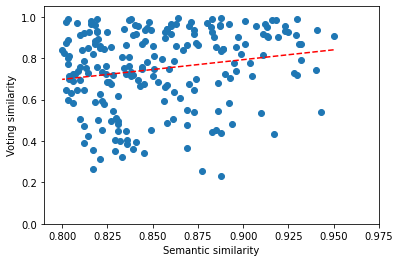

In [23]:
plt.plot(migratie['semantic similarity'], migratie['voting_similarity'], 'o') #plotting similarities
plt.xlim([0.79, 0.975]) #setting limit to better see datapoints
plt.ylim([0, 1.05]) #setting limit to better see datapoints
plt.xlabel("Semantic similarity") #changing labels x-axis
plt.ylabel("Voting similarity") #changing labels y-axis

z = np.polyfit(migratie['semantic similarity'], migratie['voting_similarity'], 1) #fit line 
p = np.poly1d(z) #mathematical representation of line
plt.plot(migratie['semantic similarity'],p(migratie['semantic similarity']),"r--") #draw line

plt.show()


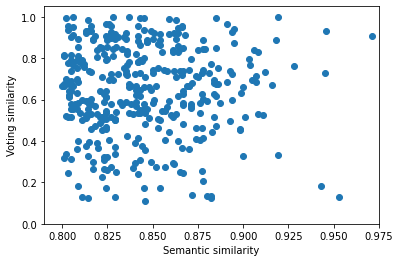

In [24]:
plt.plot(sexualiteit['semantic similarity'], sexualiteit['voting_similarity'], 'o')
plt.xlim([0.79, 0.975])
plt.ylim([0, 1.05])
plt.xlabel("Semantic similarity")
plt.ylabel("Voting similarity")
plt.show()



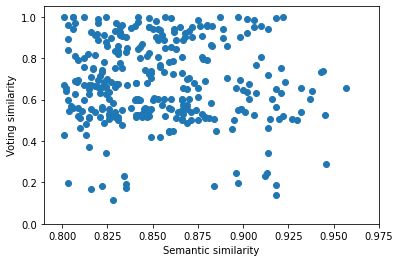

In [25]:
plt.plot(religie['semantic similarity'], religie['voting_similarity'], 'o')
plt.xlim([0.79, 0.975])
plt.ylim([0, 1.05])
plt.xlabel("Semantic similarity")
plt.ylabel("Voting similarity")
plt.show()


213

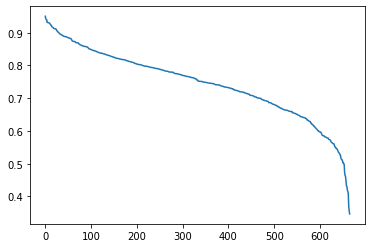

In [26]:
mig_t = mig_df
mig_t = mig_t['semantic similarity'].reset_index()
mig_t['semantic similarity'].plot.line() #line plot similarity
len(mig_t.loc[mig_t['semantic similarity'] >= 0.8]) #count leftover pairs of statements


376

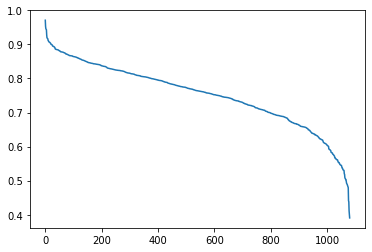

In [27]:
mig_f = sex_df
mig_f = mig_f['semantic similarity'].reset_index()
mig_f['semantic similarity'].plot.line() #line plot similarity
len(mig_f.loc[mig_f['semantic similarity'] >= 0.8]) #count leftover pairs of statements

310

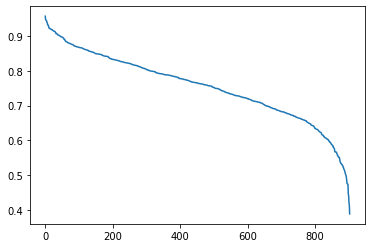

In [28]:
mig_d = rel_df
mig_d = mig_d['semantic similarity'].reset_index()
mig_d['semantic similarity'].plot.line() #line plot similarity
len(mig_d.loc[mig_d['semantic similarity'] >= 0.8]) #count leftover pairs of statements